**Étapes pour utiliser le code :**

1. Préparez votre dataset comme décrit, avec les images dans un dossier et le fichier CSV des labels.

2. Mettez à jour les variables DATA_DIR, CSV_FILE, IMAGE_DIR, et surtout la liste EMOTION_LABELS pour qu'elle corresponde exactement à vos émotions et l'ordre de vos colonnes dans le CSV.

3. Exécutez le script.

4. Surveillez la console pour les métriques d'entraînement et de validation. Ajustez les hyperparamètres (BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, FREEZE_FEATURES) si nécessaire en fonction des performances observées.

**Organisation des données :**

your_dataset/

├── images/

│   ├── image_001.jpg

│   ├── image_002.jpg

│   └── ...

└── labels.csv # Ou un autre format de fichier, contenant les chemins d'images et leurs étiquettes

**Format du dataset :**

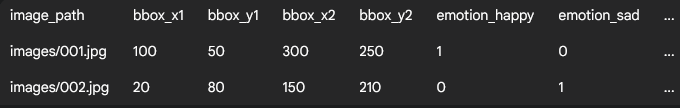

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models#, transforms
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import time
import copy
import onnx
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
import numpy as np
from tqdm import tqdm # Pour les barres de progression

#import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.5.1+cu121'

On a le choix de fine tuner la dernière couche OU tout le modele (pas le même temps)

# I/ Configuration et Hyperparamètres 

In [3]:
# --- 0. Configuration et Hyperparamètres ---
DATA_DIR = r'C:\Users\alber\Desktop\visual_studio_code\dossier_jedha\Jedha_Full_stack\00_Final_Project\set\DAiSEE_small' # Chemin vers votre dossier racine du dataset
CSV_FILE = os.path.join(DATA_DIR, 'labels_daisee_continous.csv') # Chemin vers votre fichier CSV d'étiquettes
IMAGE_DIR = os.path.join(DATA_DIR, 'Dataset') # Chemin vers le dossier contenant les images

# Définissez vos émotions binaires ici, dans le même ordre que vos colonnes dans le CSV
EMOTION_LABELS = ['boredom', 
                  'confusion',
                  'engagement', 
                  'frustration'
]

NUM_CLASSES = len(EMOTION_LABELS)

BATCH_SIZE = 32 
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
FREEZE_FEATURES = True # True pour ne fine-tuner que la dernière couche, False pour fine-tuner tout le modèle

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du périphérique : {DEVICE}")

Utilisation du périphérique : cuda:0


# II/ Création du Dataset PyTorch personnalisé (modifié)

In [4]:
# --- 1. Création du Dataset PyTorch personnalisé (modifié) ---
class EmotionDataset(Dataset):
    def __init__(self, df, img_dir, emotion_cols, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.emotion_cols = emotion_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_path'])

        emotion_labels = row[self.emotion_cols].values.astype(float)
        emotion_labels = torch.tensor(emotion_labels, dtype=torch.float32)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, emotion_labels

# III/ Transformations d'images

In [5]:
# --- 2. Transformations d'images ---
# Transformations pour l'entraînement (augmentation des données)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Recadrage aléatoire et redimensionnement à 224x224
        transforms.RandomHorizontalFlip(), # Retournement horizontal aléatoire
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Jitter de couleur
        transforms.ToTensor(), # Convertir en Tensor PyTorch (met les pixels entre 0 et 1)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalisation (moyenne et std ImageNet)
    ]),
    # Transformations pour la validation/test (juste redimensionnement et normalisation)
    'val': transforms.Compose([
        transforms.Resize(256), # Redimensionner le plus petit côté à 256
        transforms.CenterCrop(224), # Centre Crop à 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

c:\Users\alber\anaconda3\envs\dl_project_py311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# IV/ Chargement des données et division Train/Val 

In [6]:
# --- 3. Chargement des données et division Train/Val ---
print("Chargement des données...")
full_df = pd.read_csv(CSV_FILE)

# Division du dataset en ensembles d'entraînement et de validation
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42) # Stratify si possible

train_dataset = EmotionDataset(df=train_df, img_dir=IMAGE_DIR, emotion_cols=EMOTION_LABELS, transform=data_transforms['train'])
val_dataset = EmotionDataset(df=val_df, img_dir=IMAGE_DIR, emotion_cols=EMOTION_LABELS, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

print(f"Taille du dataset d'entraînement : {dataset_sizes['train']}")
print(f"Taille du dataset de validation : {dataset_sizes['val']}")

Chargement des données...
Taille du dataset d'entraînement : 6335
Taille du dataset de validation : 1584


# V/ Chargement du modèle ResNet18 pré-entraîné

In [ ]:
print("Chargement et modification du modèle ResNet18 pré-entraîné...")

# 1. Chargement du modèle ResNet18 pré-entraîné sur ImageNet

# choix 1 => Resnet18
# model_ft = models.resnet18(weights="IMAGENET1K_V1")

# choix 2 => efficentnet
model_ft = models.efficientnet_b4(weights="IMAGENET1K_V1")

# # choix 2.1 => mobile net
# model_ft = models.mobilenet_v2(weights='IMAGENET1K_V1')

# choix 3 => efficentnet
# model_ft = models.efficientnet_b7(weights="IMAGENET1K_V1")

# choix 3  bis => convex_tiny 

# choix 4 => Resnet50
# model_ft = models.resnet50(weights="IMAGENET1K_V1")


print("Freeze des couches convolutionnelles...")

# 2. On gèle les couches de feature extraction
for param in model_ft.parameters():
    param.requires_grad = False

#fine_tune_at = len(list(model_ft.children())) - 10
for name, param in list(model_ft.named_parameters())[-17:]:
    print(name)
    param.requires_grad = True

print("Définition de la dernière couche...")

# 3. Remplacement de la couche fully-connected finale

# Resnet18
# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.BatchNorm1d(512),
#     nn.ReLU(),
#     nn.Dropout(0.1),
#     nn.Linear(512, NUM_CLASSES)
# )

# Efficientnet 
num_ftrs = model_ft.classifier[1].in_features

model_ft.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)

# 4. Envoi du modèle sur le bon device (GPU ou CPU)
model_ft = model_ft.to(DEVICE)

print("Modèle prêt ! ✅")


Chargement et modification du modèle ResNet18 pré-entraîné...
Freeze des couches convolutionnelles...
features.7.1.block.0.1.weight
features.7.1.block.0.1.bias
features.7.1.block.1.0.weight
features.7.1.block.1.1.weight
features.7.1.block.1.1.bias
features.7.1.block.2.fc1.weight
features.7.1.block.2.fc1.bias
features.7.1.block.2.fc2.weight
features.7.1.block.2.fc2.bias
features.7.1.block.3.0.weight
features.7.1.block.3.1.weight
features.7.1.block.3.1.bias
features.8.0.weight
features.8.1.weight
features.8.1.bias
classifier.1.weight
classifier.1.bias
Définition de la dernière couche...
Modèle prêt ! ✅


In [8]:
from torchinfo import summary

summary(model_ft, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 4]                    --
├─Sequential: 1-1                                       [1, 1792, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 48, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 48, 112, 112]         (1,296)
│    │    └─BatchNorm2d: 3-2                            [1, 48, 112, 112]         (96)
│    │    └─SiLU: 3-3                                   [1, 48, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 24, 112, 112]         (2,940)
│    │    └─MBConv: 3-5                                 [1, 24, 112, 112]         (1,206)
│    └─Sequential: 2-3                                  [1, 32, 56, 56]           --
│    │    └─MBConv: 3-6                    

# VI/ Fonction de perte et Optimiseur

In [9]:
# def weighted_mse_loss(predictions, labels, weight_vector):
#     # get squared error on predictions
#     squared_diff = (predictions - labels)**2

#     # find which labels are positive or not (this will define which losses we weight)
#     positive_label_mask = (labels > 0)
    
#     # set weight to 1 if mask == 0 and weight otherwise
#     weights = torch.where(positive_label_mask == 1, weight_vector, 1)

#     weighted_squared_diff = weights * squared_diff

#     return torch.mean(weighted_squared_diff)

In [10]:
# --- 5. Fonction de perte et Optimiseur ---
# Pour la classification multi-label, Binary Cross-Entropy with Logits Loss est la norme.
# Elle combine une couche Sigmoid et la Binary Cross-Entropy.
# Perte pour la classification multi-label des émotions

# criterion_emotions = nn.BCEWithLogitsLoss(pos_weight=div2_emotion_weights)
criterion_emotions = nn.MSELoss()
# criterion_emotions = raph_fonction => in test

# Seulement les paramètres qui nécessitent des gradients seront optimisés
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

# Ordonnanceur de taux d'apprentissage (réduit le LR après un certain nombre d'époques)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# VII/ Fonction d'entraînement et d'évaluation

In [11]:
# --- 6. Fonction d'entraînement et d'évaluation ---

def train_model(model, 
                criterion_emotions, 
                optimizer, 
                train_loader, 
                val_loader, 
                device, 
                scheduler=None,
                epochs=NUM_EPOCHS,
                output_names=EMOTION_LABELS):
    
    since = time.time()
    
    history = {'train_loss': [],
                'val_loss': [],
                'val_MAE': [],
                'val_MSE': [],
                'val_RMSE': [],
                'val_R2': []}

    model.to(device)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print('-' * 30)

        ### -------- TRAIN --------
        model.train()
        running_loss = 0.0


        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion_emotions(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * inputs.size(0)
            

        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)

        ### -------- VAL --------
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_true_values = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion_emotions(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Convertir les tenseurs en numpy pour calculer les métriques sklearn
                val_predictions.extend(outputs.cpu().numpy())
                val_true_values.extend(labels.cpu().numpy())


        # Convertir les listes en numpy array pour sklearn
        val_true_values_np = np.array(val_true_values)
        val_predictions_np = np.array(val_predictions)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_MAE = mean_absolute_error(val_true_values_np, val_predictions_np)
        val_epoch_MSE = mean_squared_error(val_true_values_np, val_predictions_np)
        val_epoch_RMSE = np.sqrt(mean_squared_error(val_true_values_np, val_predictions_np))
        val_epoch_r2 = r2_score(val_true_values_np, val_predictions_np)
        
        history['val_loss'].append(val_epoch_loss)
        history['val_MAE'].append(val_epoch_MAE)
        history['val_MSE'].append(val_epoch_MSE)
        history['val_RMSE'].append(val_epoch_RMSE)
        history['val_R2'].append(val_epoch_r2)
       
        print(f"Train Loss: {epoch_loss:.4f} | "
            f"Val Loss: {val_epoch_loss:.4f} | "
            f"Val MAE: {val_epoch_MAE:.4f} | "
            f"Val MSE: {val_epoch_MSE:.4f} | "
            f"Val RMSE: {val_epoch_RMSE:.4f} | "
            f"Val R2: {val_epoch_r2:.4f} \n ")
        
        all_metrics={}
        
        for i, name in enumerate(output_names):
                true_i = val_true_values_np[:,i]
                pred_i = val_predictions_np[:,i]
                
                mae_i = mean_absolute_error(true_i, pred_i)
                mse_i = mean_squared_error(true_i, pred_i)
                rmse_i = np.sqrt(mse_i)
                r2_i = r2_score(true_i, pred_i)
                
                all_metrics[f'{name}_MAE'] = mae_i
                all_metrics[f'{name}_MSE'] = mse_i
                all_metrics[f'{name}_RMSE'] = rmse_i
                all_metrics[f'{name}_R2'] = r2_i

                print(f"{name}: MAE: {mae_i:.4f}, MSE: {mse_i:.4f}, RMSE: {rmse_i:.4f}, R2 Score: {r2_i:.4f}")

        if scheduler:
            scheduler.step()

    time_elapsed = time.time() - since
    print(f"\n🕒 Entraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

    return history


In [ ]:
# # for i, name in enumerate(EMOTION_LABELS):
# #     print(i)

# option 1 
# pour l'evaluation

# => sortir mae mse 

# => recuperer les outputs et labels 
# regression => param de seuil => classification 
# classification report 

# option 2
# => preprocess donne entre 0/1 

SyntaxError: invalid syntax (2425740520.py, line 12)

# VIII/ Lancement de l'entraînement 

In [13]:
# --- 7. Lancement de l'entraînement ---
print("\nDébut de l'entraînement...\n")
history = train_model(model=model_ft,
                        criterion_emotions=criterion_emotions,
                        optimizer=optimizer_ft,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        device=DEVICE,
                        scheduler=exp_lr_scheduler,
                        epochs=2,
                        output_names=EMOTION_LABELS)



Début de l'entraînement...


Epoch 1/2
------------------------------
Train Loss: 0.7055 | Val Loss: 0.4864 | Val MAE: 0.5461 | Val MSE: 0.4864 | Val RMSE: 0.6974 | Val R2: 0.0174 
 
boredom: MAE: 0.7117, MSE: 0.7205, RMSE: 0.8488, R2 Score: 0.1159
confusion: MAE: 0.5081, MSE: 0.4484, RMSE: 0.6696, R2 Score: 0.0455
engagement: MAE: 0.5258, MSE: 0.4218, RMSE: 0.6495, R2 Score: -0.1033
frustration: MAE: 0.4387, MSE: 0.3549, RMSE: 0.5957, R2 Score: 0.0114

Epoch 2/2
------------------------------
Train Loss: 0.5383 | Val Loss: 0.4680 | Val MAE: 0.5219 | Val MSE: 0.4680 | Val RMSE: 0.6841 | Val R2: 0.0556 
 
boredom: MAE: 0.6922, MSE: 0.6904, RMSE: 0.8309, R2 Score: 0.1530
confusion: MAE: 0.4804, MSE: 0.4415, RMSE: 0.6645, R2 Score: 0.0602
engagement: MAE: 0.5175, MSE: 0.4135, RMSE: 0.6430, R2 Score: -0.0815
frustration: MAE: 0.3974, MSE: 0.3264, RMSE: 0.5713, R2 Score: 0.0906

🕒 Entraînement terminé en 2m 43s


# IX/ Enregistrement model + export

In [15]:
# Chemin de sauvegarde
onnx_export_path = "daisee_model.onnx"

# Dummy input — doit correspondre à la taille attendue par ton modèle
dummy_input = torch.randn(1, 3, 224, 224, device=DEVICE)

# Export ONNX
torch.onnx.export(
    model_ft,                  # Le modèle entraîné
    dummy_input,               # Un exemple d'input
    onnx_export_path,          # Chemin de sortie
    input_names=['input'],     # Nom de l'input
    output_names=['output'],   # Nom de la sortie
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    opset_version=11,          # Version de l'opset ONNX (11 est sûr pour la compatibilité)
    do_constant_folding=True   # Optimisation pour les constantes
)

print(f"✅ Modèle exporté au format ONNX : {onnx_export_path}")


✅ Modèle exporté au format ONNX : daisee_model.onnx


In [ ]:
# # --- 8. Sauvegarde du modèle entraîné ---
# # Créez un dossier pour les modèles si n'existe pas
# os.makedirs('saved_models', exist_ok=True)
# model_save_path = os.path.join('saved_models', 'resnet18_emotion_dav_multi_person.pth')
# torch.save(model_ft.state_dict(), model_save_path)
# print(f"Modèle sauvegardé à : {model_save_path}")

In [ ]:
# --- 9. (Optionnel) Évaluation finale sur l'ensemble de validation ---
# Charger le modèle pour l'évaluation
# model_ft.eval() # Mettre en mode évaluation
# ... Vous pouvez réutiliser le code d'évaluation de la fonction train_model ici si vous voulez une évaluation finale séparée.

print("\n--- Entraînement terminé ---")

In [ ]:
# import onnxruntime as ort
# import numpy as np
# from torchvision import transforms
# from PIL import Image

# # Charger le modèle ONNX
# session = ort.InferenceSession("emotic_model.onnx")

# # Charger et prétraiter une image
# img_path = "chemin/vers/image.jpg"
# image = Image.open(img_path).convert("RGB")

# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], 
#                          [0.229, 0.224, 0.225])
# ])

# input_tensor = transform(image).unsqueeze(0).numpy()  # (1, 3, 224, 224)

# # Faire une prédiction
# outputs = session.run(['output'], {'input': input_tensor})
# preds = outputs[0]

# # Résultat
# print("Prédiction brute :", preds)
